# Predict the weekly sales of walmart stores by section using historical sales, markdown data and macro-economic indicators 

- Price Markdown is a method of reducing the sale price of a product

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#reading the required data files
sales_data = pd.read_csv('/Volumes/Mac-RKP/Data science/Dezyre/Walmart Forecasting/sales_data.csv')
features_data = pd.read_csv('/Volumes/Mac-RKP/Data science/Dezyre/Walmart Forecasting/features.csv')
stores_data = pd.read_csv('/Volumes/Mac-RKP/Data science/Dezyre/Walmart Forecasting/stores.csv')

# Exploratory Data Analysis (EDA)

In [3]:
sales_data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [4]:
sales_data.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [5]:
sales_data.dtypes

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
dtype: object

In [6]:
sales_data.shape

(421570, 5)

In [7]:
sales_data.nunique()

Store               45
Dept                81
Date               143
Weekly_Sales    359464
IsHoliday            2
dtype: int64

In [8]:
sales_data.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


In [9]:
#now we wanna see if this is a systematic issue or random
sales_data_check = sales_data.loc[sales_data['Weekly_Sales'] <= 0]
sales_data_check.shape

(1358, 5)

In [10]:
sales_data_check.nunique()

Store            45
Dept             51
Date            143
Weekly_Sales    679
IsHoliday         2
dtype: int64

In [11]:
sales_data_check.shape[0]/sales_data.shape[0]

0.003221291837654482

In [12]:
sales_data['Store'] = sales_data['Store'].astype(str)
sales_data['Dept'] = sales_data['Dept'].astype(str)
sales_data['IsHoliday'] = sales_data['IsHoliday']*1

In [13]:
#Since it affects a small percentage of the data, lets drop these records
sales_data2 = sales_data.loc[sales_data['Weekly_Sales']>0]
sales_data2.shape

(420212, 5)

In [14]:
sales_data2.dtypes

Store            object
Dept             object
Date             object
Weekly_Sales    float64
IsHoliday         int64
dtype: object

In [15]:
#Creating a function that does all of the above tasks in one go
def get_basic_stats(dfname):
    print("Shape of dataframe is " + str(dfname.shape))
    print("Below are datatypes of columns in DF")
    print(dfname.dtypes.sort_values())
    print("Below are missing values in each column")
    print(dfname.isna().sum().sort_values())
    print("Below are the number of unique values taken by a column")
    print(dfname.nunique().sort_values())
    print("Below are some records in DF")
    print(dfname.head())
    print("Basic Stats for numeric variables")
    print(dfname.describe())

In [16]:
get_basic_stats(features_data)

Shape of dataframe is (8190, 12)
Below are datatypes of columns in DF
IsHoliday          bool
Store             int64
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
Date             object
dtype: object
Below are missing values in each column
Store              0
Date               0
Temperature        0
Fuel_Price         0
IsHoliday          0
CPI              585
Unemployment     585
MarkDown5       4140
MarkDown1       4158
MarkDown3       4577
MarkDown4       4726
MarkDown2       5269
dtype: int64
Below are the number of unique values taken by a column
IsHoliday          2
Store             45
Date             182
Unemployment     404
Fuel_Price      1011
CPI             2505
MarkDown2       2715
MarkDown3       2885
MarkDown4       3405
MarkDown1       4023
MarkDown5       4045
Temperature     4178
dtype: int64
Be

get_basic_stats(stores_data)

In [17]:
get_basic_stats(stores_data)

Shape of dataframe is (45, 3)
Below are datatypes of columns in DF
Store     int64
Size      int64
Type     object
dtype: object
Below are missing values in each column
Store    0
Type     0
Size     0
dtype: int64
Below are the number of unique values taken by a column
Type      3
Size     40
Store    45
dtype: int64
Below are some records in DF
   Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875
Basic Stats for numeric variables
           Store           Size
count  45.000000      45.000000
mean   23.000000  130287.600000
std    13.133926   63825.271991
min     1.000000   34875.000000
25%    12.000000   70713.000000
50%    23.000000  126512.000000
75%    34.000000  202307.000000
max    45.000000  219622.000000


In [18]:
#coverting variable to correct datatype
features_data['Store'] = features_data['Store'].astype(str)
stores_data['Store'] = stores_data['Store'].astype(str)

In [19]:
features_data2 = features_data.drop(['IsHoliday'], axis=1)

# Missing Value Imputation

In [20]:
features_data2['Unemployment'].fillna(features_data2['Unemployment'].mean(), inplace=True)
features_data2['CPI'].fillna(features_data2['CPI'].mean(), inplace=True)

In [21]:
#Markdown variables are missing in over half of the cases, and the most logical reason for that seems to be the absence \
#of any markdown in those cases  
features_data2.fillna(0, inplace=True)

In [22]:
stores_data.groupby('Type').agg({'Size':'mean'})

,Size
Type,
A,177247.727273
B,101190.705882
C,40541.666667


# Data preparation

In [23]:
#Stores unique key = Store
#Features Data - Store+Date
#Store+Dept+Date

In [24]:
features_data2.groupby(['Store', 'Date']).size().shape[0] - features_data2.shape[0]

0

In [25]:
sales_data.groupby(['Store', 'Dept', 'Date']).size().shape[0] - sales_data.shape[0]

0

In [26]:
#Merging datasets
sales_features_data = pd.merge(sales_data2, features_data2, on=['Store', 'Date'], how='inner')
sales_features_data.shape

(420212, 14)

In [27]:
combined_data = pd.merge(sales_features_data, stores_data, on='Store', how='inner')
combined_data.shape

(420212, 16)

# Dividing data into train and test 

In [28]:
#getting the date variable in the correct format
combined_data['Date2'] = pd.to_datetime(combined_data['Date'], format = '%Y-%m-%d')

In [29]:
#match the number of weeks of difference with the number of distinct weeks in the data
print(combined_data['Date2'].nunique())
(combined_data['Date2'].max() - combined_data['Date2'].min())/7#1 week should be added to this

143


Timedelta('142 days 00:00:00')

In [30]:
#Getting the date that comes at 70% of the data and using it to divide the original data
unique_dates = pd.DataFrame(combined_data['Date2'].unique(), columns = ['date'])
unique_dates.sort_values('date', inplace = True)
splitter = round(unique_dates.shape[0]*0.7, 0)
split_date=unique_dates.iloc[int(splitter)-1]['date']
split_date

Timestamp('2011-12-30 00:00:00')

In [31]:
#Using that date to make the split
combined_data_train = combined_data.loc[combined_data['Date2'] <= split_date]
combined_data_test = combined_data.loc[combined_data['Date2'] > split_date]
combined_data_train.shape[0]/combined_data.shape[0]

0.6977525629920136

# Univariate Analysis

(array([7157., 7140., 6309., 7175., 6286., 7121., 6796., 6909., 6158.,
        7206., 6988., 6736., 7324., 6995., 6886., 6482., 6823., 6818.,
        7077., 7119., 6651., 6733., 7017., 7137., 6824., 6867., 7127.,
        7058., 6604., 4990., 7071., 7122., 4470., 7177., 6586., 4321.,
        4947., 5066., 6885., 6979., 6987., 4729., 4707., 4932., 6712.]),
 array([ 0.        ,  0.97777778,  1.95555556,  2.93333333,  3.91111111,
         4.88888889,  5.86666667,  6.84444444,  7.82222222,  8.8       ,
         9.77777778, 10.75555556, 11.73333333, 12.71111111, 13.68888889,
        14.66666667, 15.64444444, 16.62222222, 17.6       , 18.57777778,
        19.55555556, 20.53333333, 21.51111111, 22.48888889, 23.46666667,
        24.44444444, 25.42222222, 26.4       , 27.37777778, 28.35555556,
        29.33333333, 30.31111111, 31.28888889, 32.26666667, 33.24444444,
        34.22222222, 35.2       , 36.17777778, 37.15555556, 38.13333333,
        39.11111111, 40.08888889, 41.06666667, 42.04444444,

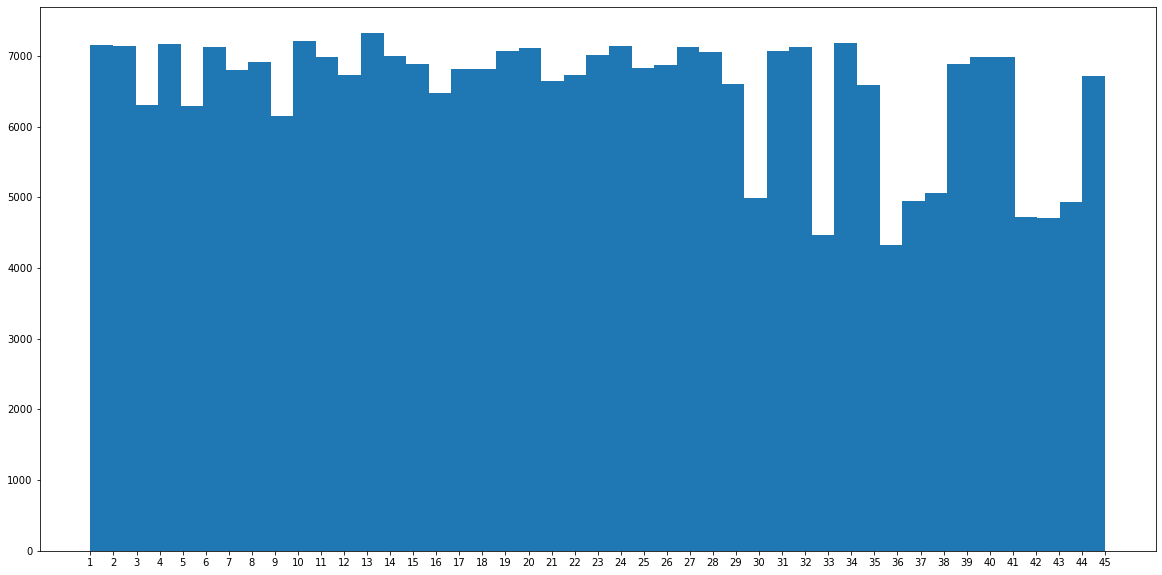

In [32]:
plt.figure(figsize=(20,10))
plt.hist(list(combined_data_train['Store']), bins = combined_data_train['Store'].nunique() )

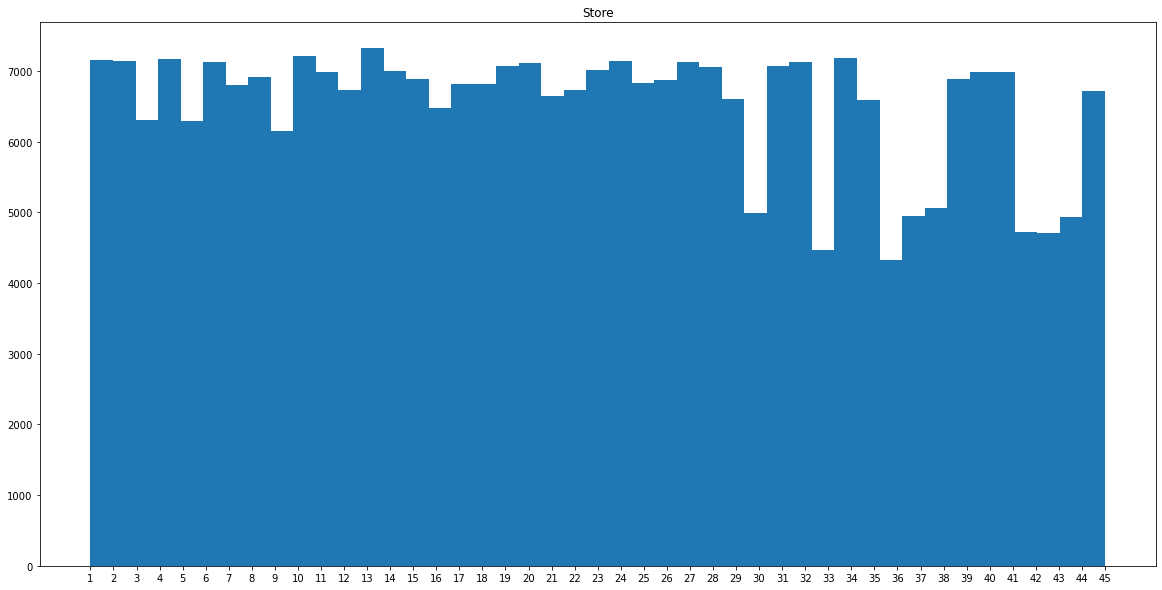

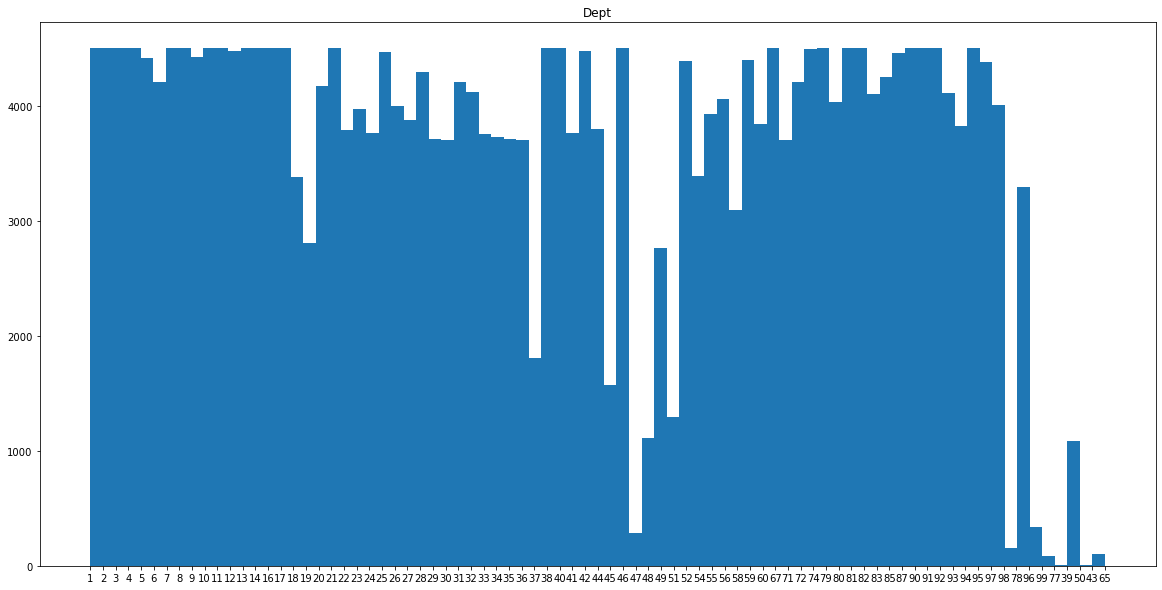

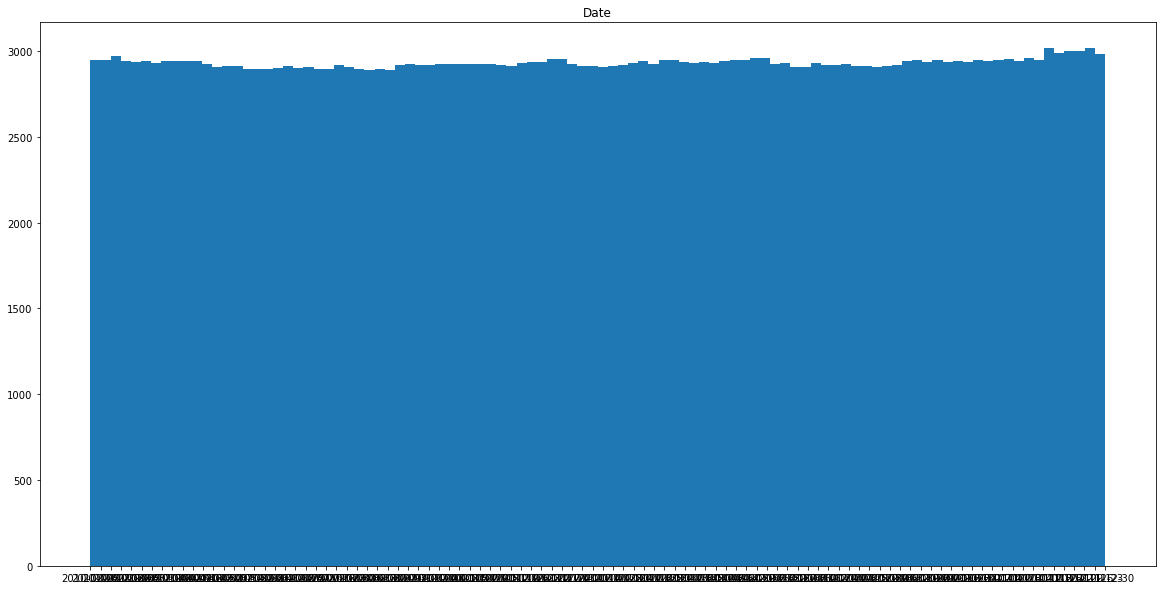

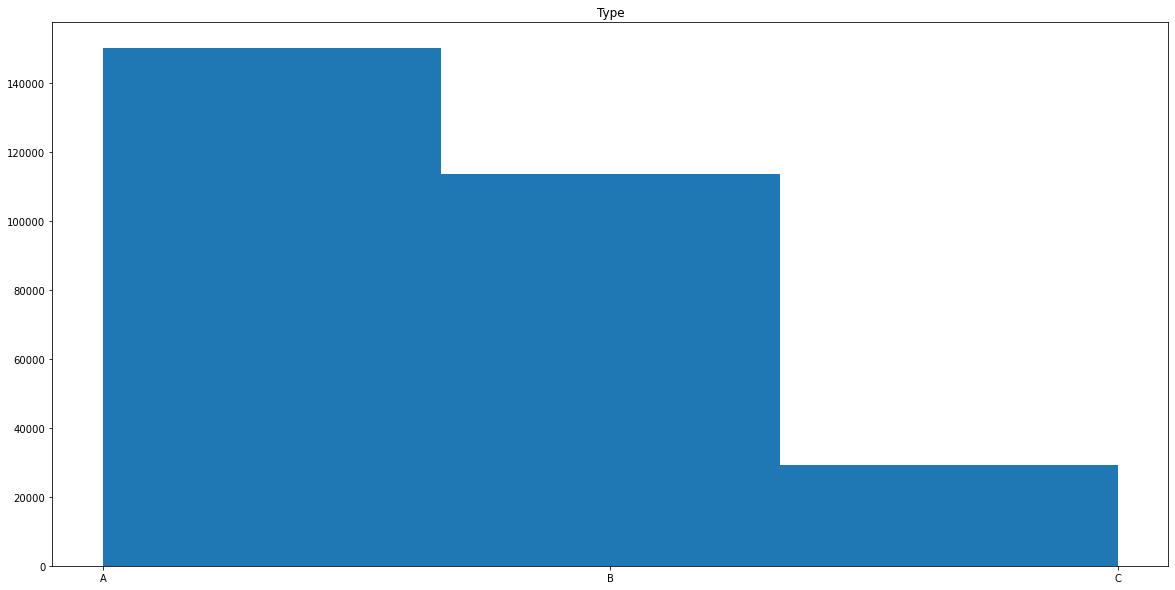

In [33]:
cat_columns = combined_data_train.select_dtypes(np.object).columns.tolist()
#univariate analysis of categorical variables
for var in cat_columns:
    plt.figure(figsize = (20,10))
    plt.hist(list(combined_data_train[var]), bins = combined_data_train[var].nunique() )
    plt.title(var)
    plt.show

In [34]:
num_columns = combined_data_train.select_dtypes(np.number).columns.tolist()
mark_columns = [x for x in num_columns if 'Mark' in x]
mark_columns
nonmark_columns = list(set(num_columns).difference(set(mark_columns)))
nonmark_columns

['Temperature',
 'CPI',
 'Weekly_Sales',
 'Size',
 'Unemployment',
 'IsHoliday',
 'Fuel_Price']

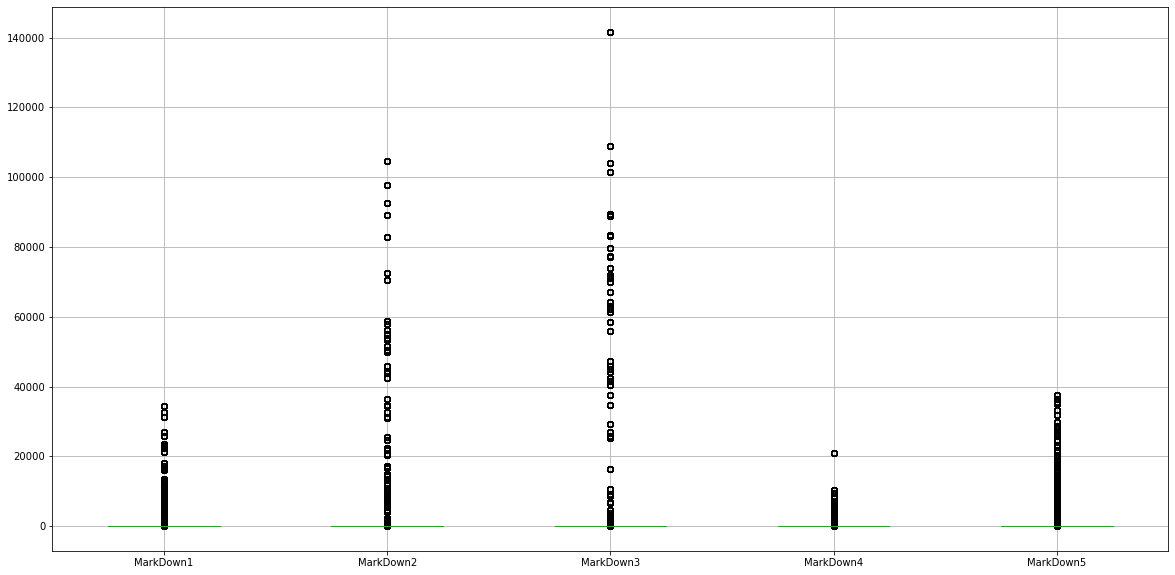

In [35]:
combined_data_train.boxplot(column = mark_columns, figsize=(20,10))

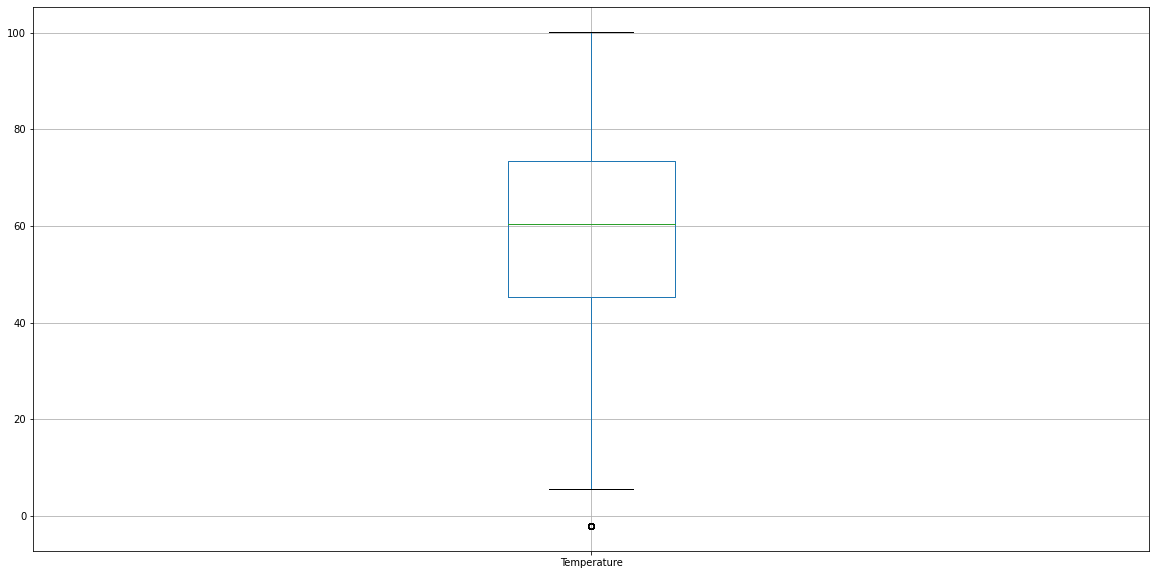

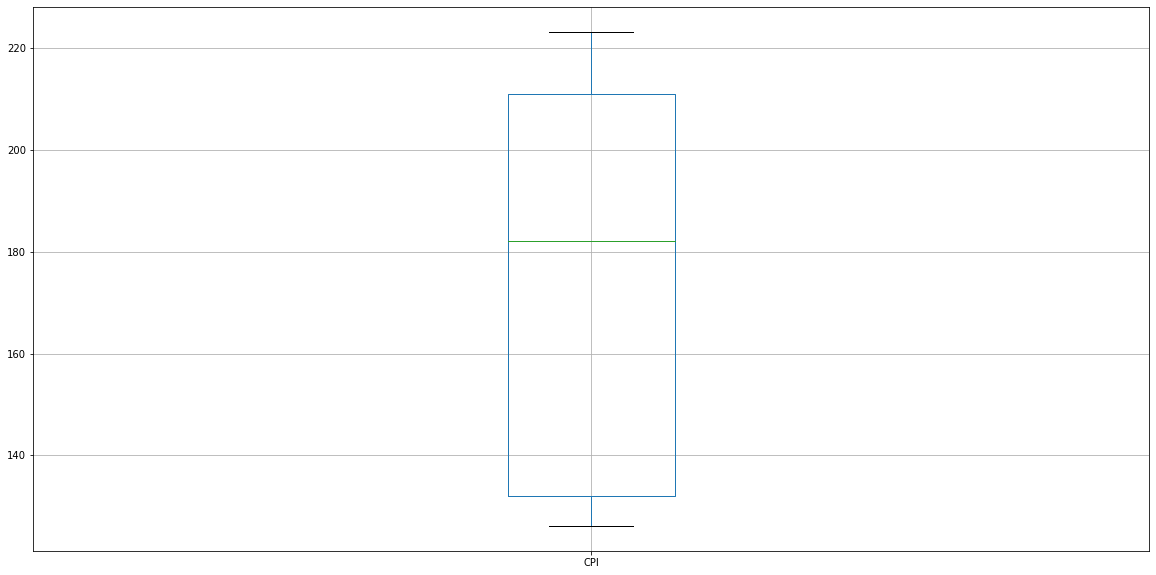

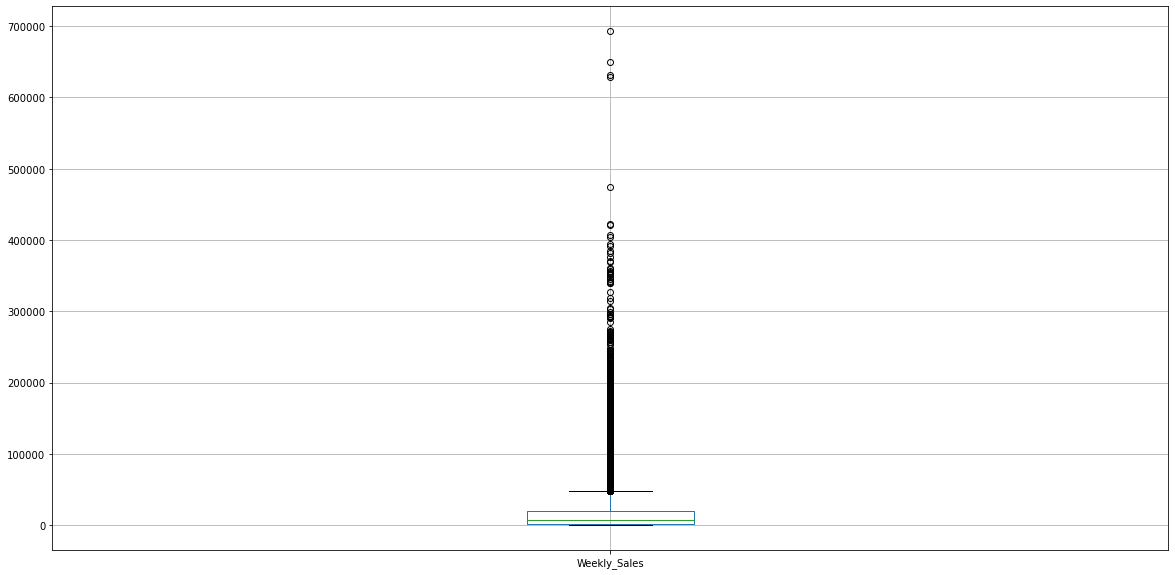

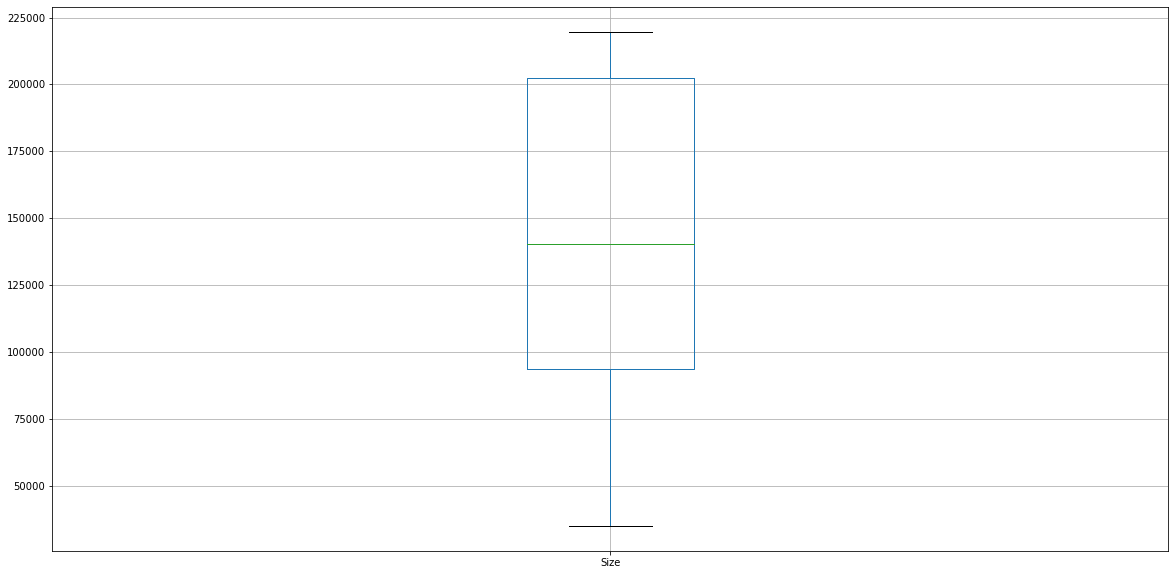

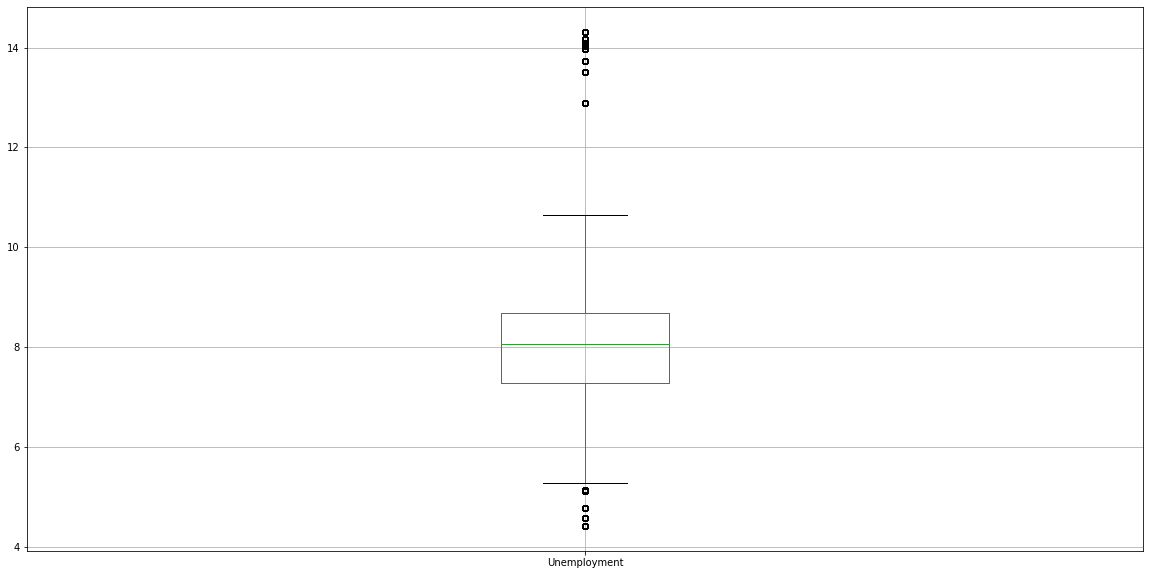

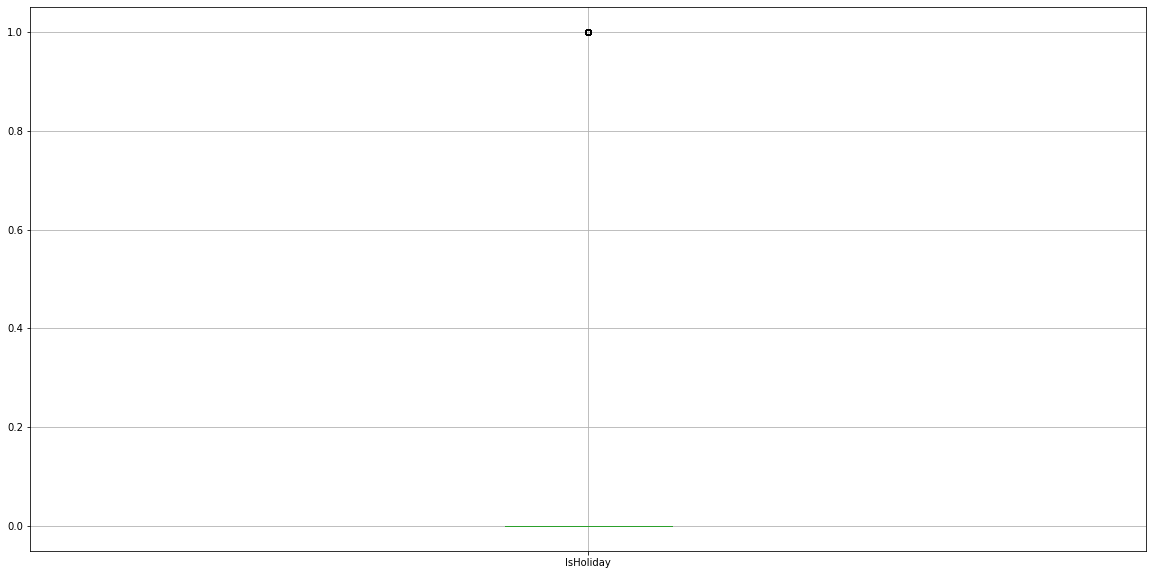

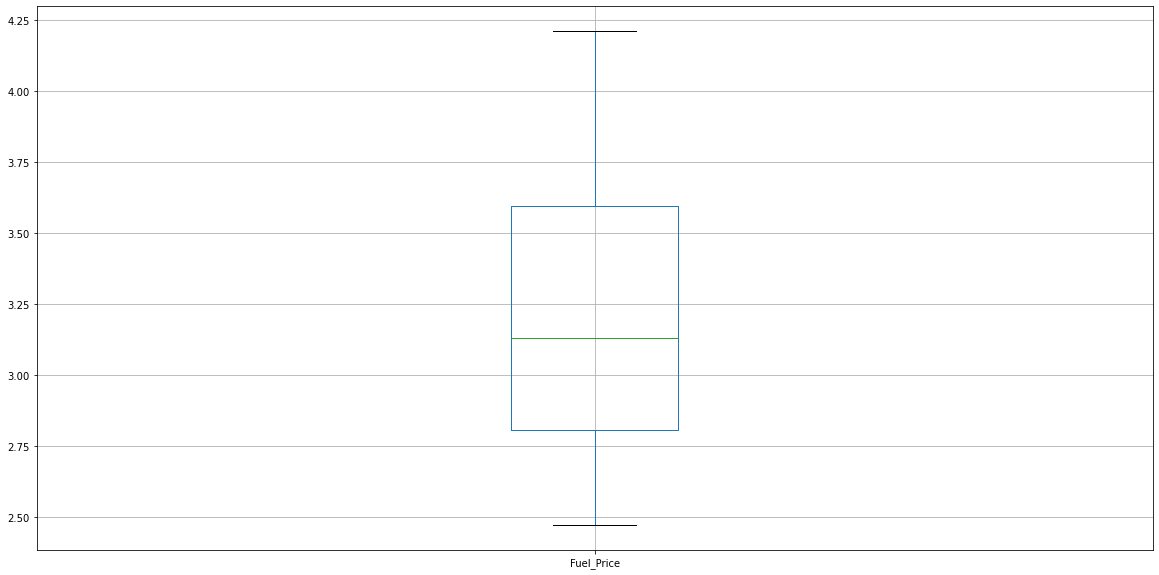

In [36]:
for var in nonmark_columns:
    combined_data_train.boxplot(column = var, figsize=(20,10))
    plt.show()

# Bivariate Analysis

In [37]:
#Keeping the numeric predictors
train_num = combined_data_train[num_columns]
train_num = train_num.drop(['Weekly_Sales'], axis=1)
train_num.head()

,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
0,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,151315
1,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,151315
2,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,151315
3,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,151315
4,0,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,151315


In [38]:
#Checking the highly correlated variables
corr_values = train_num.corr().unstack().reset_index()
print(corr_values.shape)
corr_values2 = corr_values[corr_values['level_0'] > corr_values['level_1'] ]
print(corr_values2.shape)
corr_values2.columns = ['var1', 'var2', 'corr_value']
corr_values2['corr_abs'] = corr_values2['corr_value'].abs()
corr_values2.sort_values( 'corr_abs', ascending=False, inplace=True)
corr_values2.head(10)

(121, 3)
(55, 3)


<ipython-input-38-a19a36a79baf>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_values2['corr_abs'] = corr_values2['corr_value'].abs()
<ipython-input-38-a19a36a79baf>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_values2.sort_values( 'corr_abs', ascending=False, inplace=True)


,var1,var2,corr_value,corr_abs
69,MarkDown4,MarkDown1,0.764146,0.764146
83,MarkDown5,MarkDown4,0.673759,0.673759
80,MarkDown5,MarkDown1,0.573937,0.573937
47,MarkDown2,MarkDown1,0.364552,0.364552
107,Unemployment,CPI,-0.298205,0.298205
55,MarkDown3,IsHoliday,0.296824,0.296824
44,MarkDown2,IsHoliday,0.272442,0.272442
70,MarkDown4,MarkDown2,0.232324,0.232324
30,Fuel_Price,CPI,-0.180454,0.180454
11,Temperature,IsHoliday,-0.178936,0.178936


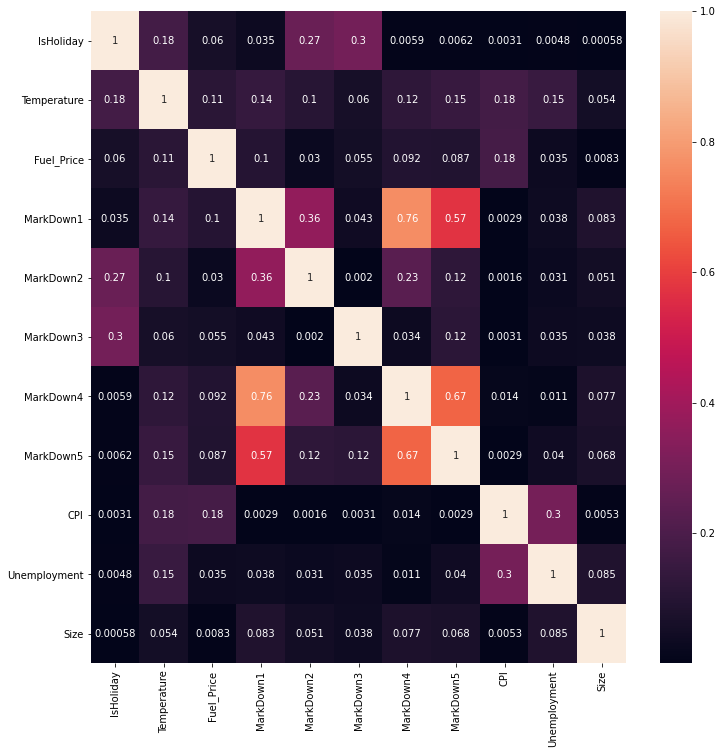

In [39]:
#creating a heat map to see the degree of correlation visually
plt.figure(figsize=(12, 12))
vg_corr = train_num.corr().abs()
sns.heatmap(vg_corr, xticklabels = vg_corr.columns.values,yticklabels = vg_corr.columns.values, annot = True)

In [ ]:
#Plotting each numeric predictor against the other
sns.pairplot(train_num)

# Variable trend with Dependent Variable

In [ ]:
#Looking at average weekly Sales by STORE, DEPT...directly taking average will lead to incorrect result..
for var in ['Store', 'Dept']:
    print(var)
    agg_temp = combined_data_train.groupby([var, 'Date'], as_index=False).agg({'Weekly_Sales': 'sum'})
    agg_temp2 = agg_temp.groupby([var], as_index=False).agg({'Weekly_Sales': 'mean'})
    agg_temp2[var] = pd.to_numeric(agg_temp2[var])
    agg_temp2.sort_values(var, inplace=True)
    print(agg_temp2.head())
    plt.figure(figsize=(20,10))
    plt.title('Avg Weekly Sales by ' + var)
    plt.barh(agg_temp2[var], agg_temp2['Weekly_Sales'])

In [ ]:
#Using scatter plot to check trend of predictors with dependent variable
var_list = [x for x in combined_data_train.columns]
columnstodrop = ['Weekly_Sales', 'Date']
var_list = list(set(var_list).difference(set(columnstodrop)))
for varname in var_list:
    plt.figure(figsize=(20,10))
    plt.scatter(combined_data_train[varname], combined_data_train['Weekly_Sales'])
    plt.xlabel(varname); plt.ylabel("Weekly_Sales")


In [ ]:
#check trend of dependent variable with other variables
all_corr = combined_data_train.corr().unstack().reset_index()
print(all_corr.shape)
corr_table = all_corr[all_corr['level_1'] =='Weekly_Sales' ]
corr_table = corr_table.loc[ (corr_table['level_0'] != 'Weekly_Sales') ]
print(corr_table.shape)
corr_table.columns = ['var1', 'var2', 'corr_value']
corr_table['corr_abs'] = corr_table['corr_value'].abs()
corr_table = corr_table.sort_values(by= ['corr_abs'], ascending = False )
corr_table

#  Date trends

In [ ]:
#Adding the week number and year column 
combined_data_train['week_number'] = combined_data_train['Date2'].dt.week
combined_data_train['year_number'] = combined_data_train['Date2'].dt.year

In [ ]:
#Checking the holiday weeks with highest total sales 
temper = combined_data_train.groupby('Date', as_index=False).agg({'Weekly_Sales':'sum'})
print(temper['Weekly_Sales'].mean())
temper = combined_data_train.groupby(['Date', 'IsHoliday', 'week_number', 'year_number'], as_index=False).agg({'Weekly_Sales':'sum'})
temper.loc[temper['IsHoliday'] == 1].sort_values(by = 'Weekly_Sales', ascending=False)

In [ ]:
#Checking the weeks with highest total sales..please note that most of them are non holidays
temper.sort_values(by = 'Weekly_Sales', ascending=False).head(20)

In [ ]:
#Checking weekly Sales of different years juxtaposed
another_agg = combined_data_train.groupby(['week_number', 'year_number', 'IsHoliday'], as_index=False).agg({ 'Weekly_Sales' : 'sum'})
plt.figure(figsize=(20,10))
plt.title('Total Juxtaposed Weekly Sales')
sns.lineplot(x="week_number", y="Weekly_Sales", hue="year_number", data = another_agg, marker = 'o')

In [ ]:
#Checking total weekly Sales of different Stores
for var in ['Store', 'Dept']:
    agg_temp = combined_data_train.groupby(['Date2', var], as_index=False).agg({ 'Weekly_Sales' : 'sum'})
    print(agg_temp.sort_values(by='Weekly_Sales', ascending=False).head(10))
    plt.figure(figsize=(20,10))
    plt.title('Total Weekly Sales by ' + var)
    agg_temp[var] = pd.to_numeric(agg_temp[var])#The hue variable has to be numerical 
    sns.lineplot(x="Date2", y="Weekly_Sales", hue=var, data = agg_temp, marker = 'o')

In [ ]:
#Checking weekly Sales of different years juxtaposed..by Store and by Dept
for var in ['Store', 'Dept']:
    another_agg = combined_data_train.groupby([var, 'week_number', 'year_number', 'IsHoliday'], as_index=False).agg({ 'Weekly_Sales' : 'sum'})
    for idd in another_agg[var].unique() :
        temper = another_agg.loc[ another_agg[var] == idd ]
        print(temper.shape)
        plt.figure(figsize=(20,10))
        plt.title('Total Juxtaposed Weekly Sales by ' + var + " " + idd)
        sns.lineplot(x="week_number", y="Weekly_Sales", hue="year_number", data = temper, marker = 'o')


# Feature Creation

In [ ]:
#marking the holiday names
conditions = [combined_data_train['IsHoliday'] == 0, combined_data_train['week_number'] == 52, combined_data_train['week_number'] == 47, \
             combined_data_train['week_number'] == 36, combined_data_train['week_number'] == 6]
choices = ['no_holiday', 'christmas', 'thanksgiving', 'labor_day', 'super_bowl']
combined_data_train['holiday_type' ] = np.select(conditions, choices, default=np.nan)
combined_data_train['holiday_type'].value_counts()

In [ ]:
#function to create sales rush weeks 
def season_variables(df):
    df['week_number'] = df['Date2'].dt.week
    df['year_number'] = df['Date2'].dt.year
    conditions = [df['IsHoliday'] == 0, df['week_number'] == 52, df['week_number'] == 47, \
                 df['week_number'] == 36, df['week_number'] == 6]
    choices = ['no_holiday', 'christmas', 'thanksgiving', 'labor_day', 'super_bowl']
    df['holiday_type' ] = np.select(conditions, choices, default=np.nan)
    print(df['holiday_type'].value_counts())
    christmas_df = pd.DataFrame(df[df['holiday_type'] == 'christmas' ]['Date2'].unique())
    christmas_df.columns = ['christmas_week']
    christmas_df['minus1'] = christmas_df['christmas_week'] -  pd.to_timedelta(7, unit='d')
    christmas_df['minus2'] = christmas_df['christmas_week'] -  pd.to_timedelta(14, unit='d')
    christmas_df['minus3'] = christmas_df['christmas_week'] -  pd.to_timedelta(21, unit='d')
    #creating all the 5 binary variables
    df['christmas_week'] = np.where(df['Date2'].isin(list(christmas_df['christmas_week']) ),1,0 )
    df['christmas_minus1'] = np.where(df['Date2'].isin(list(christmas_df['minus1']) ),1,0 )
    df['christmas_minus2'] = np.where(df['Date2'].isin(list(christmas_df['minus2']) ),1,0 )
    df['christmas_minus3'] = np.where(df['Date2'].isin(list(christmas_df['minus3']) ),1,0 )
    df['thanksgiving_week'] = np.where(df['holiday_type'] == 'thanksgiving', 1, 0)
    print(df['christmas_week'].value_counts())
    print(df['christmas_minus1'].value_counts())
    print(df['christmas_minus2'].value_counts())
    print(df['christmas_minus3'].value_counts())
    print(df['thanksgiving_week'].value_counts())
    return df

In [ ]:
combined_data_train = season_variables(combined_data_train)

In [ ]:
combined_data_test = season_variables(combined_data_test)

In [ ]:
#Creating another feature..Prediction based on Store and Dept
store_dept_median = combined_data_train.groupby(['Store', 'Dept'], as_index=False).agg({'Weekly_Sales' :  ['median']})
print(store_dept_median.shape)
store_dept_median.columns = ["_".join(x) for x in store_dept_median.columns.ravel()]
store_dept_median.columns = ['Store', 'Dept', 'Weekly_Sales_median']
print(store_dept_median.head())


In [ ]:
#Adding the feature into train and test data
print(combined_data_train.shape)
combined_data_train2 = pd.merge(combined_data_train, store_dept_median, on=['Store', 'Dept'], how='left')
print(combined_data_train2.shape)
print(combined_data_test.shape)
combined_data_test2 = pd.merge(combined_data_test, store_dept_median, on=['Store', 'Dept'], how='left')
print(combined_data_test2.shape)

In [ ]:
#Filling the few missing values for new feature in test data with mean
combined_data_test2['Weekly_Sales_median'].fillna(combined_data_test2['Weekly_Sales_median'].mean() , inplace=True)

# Modeling

# Prediction 1

In [ ]:
#Prediction based on Store, Dept and Week
simple_prediction = combined_data_train.groupby(['Store', 'Dept', 'week_number'], as_index=False).agg({'Weekly_Sales' :  ['mean', 'count' ]})
print(simple_prediction.shape)
simple_prediction.columns = ["_".join(x) for x in simple_prediction.columns.ravel()]
simple_prediction = simple_prediction.drop(['Weekly_Sales_count'], axis=1)
simple_prediction.columns = ['Store', 'Dept', 'week_number', 'Sales_prediction']
simple_prediction['prediction_type'] = 1
simple_prediction.head()

In [ ]:
pd.merge(combined_data_test, simple_prediction, on = ['Store', 'Dept', 'week_number']).shape

In [ ]:
#Prediction based on Dept..since previous prediction will miss required combinations..
#this is being done to provide approximation for sales in a dept irrespective of size 
moresimple_prediction = combined_data_train.groupby(['Dept'], as_index=False).agg({'Weekly_Sales' :  ['mean', 'count' ]})
print(moresimple_prediction.shape)
moresimple_prediction.columns = ["_".join(x) for x in moresimple_prediction.columns.ravel()]
print(moresimple_prediction['Weekly_Sales_count'].describe())
moresimple_prediction = moresimple_prediction.drop(['Weekly_Sales_count'], axis=1)
moresimple_prediction.columns = ['Dept', 'Sales_prediction']
moresimple_prediction['prediction_type'] = 2
moresimple_prediction.head()

In [69]:
#making sure there is no more than one entry for this combo
def score_direct(df_to_score, pred_df1, pred_df2):
    """
    We will use the 2 set of predictions made to estimate sales on the test data 
    """
    df_to_score['week_number'] =  df_to_score['Date2'].dt.week
    df_input = df_to_score[['Store', 'Dept', 'Date2',  'week_number']]
    print(df_input.shape)
    #checking if there is only 1 entry per combination being used to predict (i.e. Store, Dept, Week Number)
    print( df_input.groupby(['Store', 'Dept', 'week_number']).size().shape )
    #Using prediction1 and separate out combinations that remain unscored
    df_scored = pd.merge(df_input, pred_df1, on= ['Store', 'Dept', 'week_number'], how='left')
    df_present = df_scored[ pd.isnull(df_scored['prediction_type']) ==False ]
    df_missed =  df_scored[ pd.isnull(df_scored['prediction_type']) ]
    df_missed = df_missed.drop(['Sales_prediction', 'prediction_type'], axis=1)
    #using prediction2 to score the unscored test data
    df_missed_scored = pd.merge(df_missed, pred_df2, on= ['Dept'], how='left')
    print(df_missed_scored['prediction_type'].isna().sum())    
    #getting the scored test data in single DF
    df_full_scored = pd.concat( [df_present, df_missed_scored ] , axis=0)
    print(df_full_scored.shape)
    print(df_full_scored['prediction_type'].value_counts() )
    return df_full_scored

In [70]:
test_full_scored = score_direct(combined_data_test, simple_prediction, moresimple_prediction)

<ipython-input-69-c8f2508644b9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_score['week_number'] =  df_to_score['Date2'].dt.week


(127008, 4)
(127008,)
0
(127008, 6)
1.0    124366
2.0      2642
Name: prediction_type, dtype: int64


# Prediction 2 - Random Forest Regression

In [71]:
#doing ohe of the categorical variables 
cat_columns = ['Type']
combined_data_train2 = pd.concat([combined_data_train2, pd.get_dummies(combined_data_train2[cat_columns], drop_first=True)], axis=1)
combined_data_test2 = pd.concat([combined_data_test2, pd.get_dummies(combined_data_test2[cat_columns], drop_first=True)], axis=1)

In [72]:
columnstodrop = ['Type' , 'Store', 'Dept', 'Date', 'Date2', 'Weekly_Sales', 'holiday_type', 'week_number', 'year_number']
X_train = combined_data_train2.drop(columnstodrop, axis = 1 )
X_test = combined_data_test2.drop(columnstodrop, axis = 1 )
print(X_train.shape)
print(X_test.shape)

(293204, 21)
(127008, 21)


In [73]:
#MarkDown4, 5  found to be over 60% correlated to other markdown variables
X_train = X_train.drop(['MarkDown4', 'MarkDown5'], axis = 1 )
X_test = X_test.drop(['MarkDown4', 'MarkDown5'], axis = 1 )


In [74]:
Y_train = combined_data_train2['Weekly_Sales']
Y_test = combined_data_test2['Weekly_Sales']
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
# RFR with hyper-parameter tuning
import time
aa = time.time()
rfr = RandomForestRegressor(random_state=42,  n_jobs = -1, max_depth = 5)#criterion = 'mse',
param_grid = { 
'n_estimators': [50, 100, 200]
}
CV_rfr = GridSearchCV(estimator = rfr, param_grid=param_grid, cv= 3)
CV_rfr.fit(X_train, Y_train)
rfr_best = CV_rfr.best_estimator_
print(rfr_best)
print(time.time() - aa)

In [ ]:
def get_FI(modelname, dfname):
    importance_list = pd.DataFrame(modelname.feature_importances_, columns=['importance'])
    varnames_list = pd.DataFrame(dfname.columns.tolist(), columns=['feature'])
    feature_importance = pd.concat([varnames_list, importance_list], axis=1, join_axes=[varnames_list.index])
    feature_importance = feature_importance.sort_values(by=['importance'], ascending=False)
    feature_importance['cum_importance'] = feature_importance['importance'].cumsum()
    return feature_importance

In [ ]:
get_FI(rfr_best, X_train)

# Prediction 3 - ARIMA, another statistical technique

In [ ]:
#Taking a example randomly to showcase ARIMA
particular_data = sales_data2.loc[(sales_data2['Store'] == '13') & (sales_data2['Dept'] == '17'), \
                                          ['Date', 'Weekly_Sales']   ]
particular_data['Date'] =  pd.to_datetime(particular_data['Date'])
particular_data.index = particular_data.Date
particular_data = particular_data.drop('Date', axis=1)
particular_data.head()

In [ ]:
particular_data_train, particular_data_test  = particular_data[particular_data.index <= split_date],  particular_data[particular_data.index > split_date]
print(particular_data_train.shape)
print(particular_data_test.shape)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(particular_data, model='multiplicative')
fig = result.plot()

In [ ]:
from pandas.plotting import autocorrelation_plot

In [ ]:
autocorrelation_plot(particular_data_train)

In [ ]:
#Running ARIMA model
from statsmodels.tsa.arima_model import ARIMA
# fit model
model = ARIMA(particular_data_train, order=(0,1,0))
model_fit = model.fit(disp=1)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [ ]:
# Install pyramid using
#pip install pmdarima
#Hyper Parameter Tuning of ARIMA model..No seasonality taken.
from pmdarima import auto_arima
auto_model = auto_arima(particular_data_train, start_p=1, d=0, start_q=1,
                           max_p=3, max_q=3, m=1,
                           start_P=0, seasonal=False,
                           D=None, trace=True,
                           error_action='ignore'
                           )#suppress_warnings=True
auto_model.fit(particular_data_train)
print(auto_model)
test_arima = auto_model.predict(n_periods= len(particular_data_test))


In [ ]:
sales_data_train = combined_data_train[['Store', 'Dept', 'Date2', 'Weekly_Sales']]
sales_data_test = combined_data_test[['Store', 'Dept', 'Date2', 'Weekly_Sales']]

In [ ]:
#checking the number of records for each store, dept combination
temper = sales_data_train.groupby(['Store', 'Dept'], as_index=False).agg({'Date2': 'count' })
temper = temper.rename(columns= {'Date2' : 'counter'})
temper.head()
temper2 = temper.groupby(['counter'], as_index=False).agg({'Store': 'count' })
temper2

In [ ]:
temper.shape

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
def arima_modeler(df_train, df_test):
    """
    Now we will create a function to create these models after hyper-parameter tuning for all the combinations of Store and Dept
    in the data    
    """
    combos_train = df_train.groupby(['Store', 'Dept'], as_index=False).agg({'Date2' : {'min', 'max', 'count'} })
    print(combos_train.shape)
    combos_test = df_test.groupby(['Store', 'Dept'], as_index=False).agg({'Date2' :  'count' })
    combos_test = combos_test[['Store', 'Dept']]
    print(combos_test.shape)
    combos_common = pd.merge(combos_train, combos_test, on = ['Store', 'Dept'])
    print(combos_common.shape)
    combos_common.columns = ["_".join(x) for x in combos_common.columns.ravel()]
    combos_common = combos_common.rename(columns = {'Store_' : 'Store', 'Dept_' : 'Dept'})
    combos_common['total_weeks'] = (combos_common['Date2_max'] - combos_common['Date2_min']).astype('timedelta64[D]')/7 + 1
    combos_common['date_gap'] = combos_common['total_weeks'] - combos_common['Date2_count']
    combos_common_nogap = combos_common.loc[combos_common['date_gap'] ==0 ]
    print(combos_common_nogap.shape)
    combos_common_nogap = combos_common_nogap.loc[combos_common_nogap['Date2_max'] == split_date ]
    combos_common_nogap = combos_common_nogap.loc[combos_common_nogap['Date2_count'] == 100 ]
    combos_common_nogap = combos_common_nogap.sort_values(by=['Store', 'Dept'])
    combos_common_nogap.reset_index(inplace=True)
    print(combos_common_nogap.shape)
    print(combos_common_nogap.head(10))
    
    sales_data_train_nogap = pd.merge(df_train, combos_common_nogap[['Store', 'Dept']], on =  ['Store', 'Dept'] )
    print(sales_data_train_nogap.shape)
    sales_data_test_nogap = pd.merge(df_test, combos_common_nogap[['Store', 'Dept']], on =  ['Store', 'Dept'] )
    print(sales_data_test_nogap.shape)#The remaining data cant be predicted

    sales_data_train_nogap = sales_data_train_nogap.sort_values(by=['Store', 'Dept', 'Date2'])
    sales_data_test_nogap = sales_data_test_nogap.sort_values(by=['Store', 'Dept', 'Date2'])
#     sales_data_test_nogap = sales_data_test_nogap[0:10000]
    
    #creating a DF that will store all the model outputs
    all_scores = pd.DataFrame(columns = ['score'])

    for i in range(len(combos_common_nogap)):#
        print(i)
        store_id = combos_common_nogap.loc[i]['Store']
        dept_id = combos_common_nogap.loc[i]['Dept']    
        print("Now the model for Store " + store_id + " and Dept " + dept_id + " will be created")
        particular_data_train = sales_data_train_nogap.loc[(sales_data_train_nogap['Store'] == store_id) & (sales_data_train_nogap['Dept'] == dept_id), \
                                              ['Date2', 'Weekly_Sales']   ]
        print(particular_data_train.shape)
        particular_data_test = sales_data_test_nogap.loc[(sales_data_test_nogap['Store'] == store_id) & (sales_data_test_nogap['Dept'] == dept_id), \
                                                  ['Date2', 'Weekly_Sales']   ]#, 'Weekly_Sales'
        print(particular_data_test.shape)
        #The date is required as index for ARIMA models
        particular_data_train.index = particular_data_train.Date2
        particular_data_test.index = particular_data_test.Date2

        particular_data_train = particular_data_train.drop('Date2', axis=1)
        particular_data_test = particular_data_test.drop('Date2', axis=1)
        
        #Hyper Parameter tuning
        auto_model = auto_arima(particular_data_train, start_p=1, d=0, start_q=1,max_p=3, max_q=3, start_P=0, trace=True)
        auto_model.fit(particular_data_train)
        print(auto_model)
        test_arima = auto_model.predict(n_periods=len(particular_data_test))
        test_arima_df  = pd.DataFrame(test_arima, columns = ['score'] )
        #appending the new scores along with the scores already obtained
        all_scores = pd.concat([all_scores, test_arima_df], axis=0)
        all_scores = all_scores.reset_index()
        all_scores = all_scores.drop(['index'], axis=1)
        print(mean_absolute_error(particular_data_test, test_arima))
    
    #getting the model scores and actuals in one file for comparison
    sales_data_test2 = sales_data_test_nogap.reset_index()
    sales_data_test2 = sales_data_test2.drop(['index'], axis=1)
    print(sales_data_test2.head())
    test_data_scored = pd.concat([sales_data_test2, all_scores], axis=1)
    return test_data_scored

In [ ]:
partialtest_scored_arima = arima_modeler(sales_data_train, sales_data_test)

In [ ]:
partialtest_scored_arima.shape

In [ ]:
sales_data_test_arima = pd.merge(sales_data_test, partialtest_scored_arima.drop(['Weekly_Sales'], axis=1), on=['Store', 'Dept', 'Date2'], how='left' )
sales_data_test_arima.isna().sum()

In [ ]:
#Making the prediction for cases where ARIMA couldnt make the prediction due to lack of data  
sales_data_test_missing =sales_data_test_arima.loc[pd.isnull(sales_data_test_arima['score']) ]
sales_data_test_mp = pd.merge(sales_data_test_missing.drop('score', axis=1) , moresimple_prediction.rename(columns = {'Sales_prediction':'score'}) , on='Dept' )
sales_data_test_mp.head()

In [ ]:
sales_data_test_mp.drop('prediction_type', axis=1, inplace=True)
fullyscored_test_arima = pd.concat([partialtest_scored_arima, sales_data_test_mp ], axis=0)
fullyscored_test_arima.shape

# Model Comparison

In [ ]:
#Getting the sales numbers in the data
test_scored_stats = pd.merge(test_full_scored, sales_data_test, on = ['Store', 'Dept', 'Date2'])
test_scored_stats.shape

In [ ]:
def rf_scorer(X_df, Y_df, model_name):
    """
    obtain the prediction and compare with the actual
    """
    scored_rf = pd.DataFrame({ 'Sales_prediction' : model_name.predict(X_df)} ) 
    scored_actuals_rf = pd.concat( [scored_rf, Y_df.reset_index() ] , axis=1)
    scored_actuals_rf = scored_actuals_rf.drop(['index'], axis = 1)
    scored_actuals_rf['error_abs_rf'] = (scored_actuals_rf['Sales_prediction'] - scored_actuals_rf['Weekly_Sales']).abs()
    print(scored_actuals_rf['error_abs_rf'].describe())
    return scored_actuals_rf

In [ ]:
#Creating absolute error metric in each dataframe
test_scored_stats['error_abs_st'] = (test_scored_stats['Weekly_Sales'] - test_scored_stats['Sales_prediction']).abs()
test_rf = rf_scorer(X_test, Y_test, rfr_best)
fullyscored_test_arima['error_abs_ar'] = (fullyscored_test_arima['Weekly_Sales'] - fullyscored_test_arima['score']).abs()

In [ ]:
#Getting Mean Absolute Error
from sklearn.metrics import mean_squared_error
import math
print( "MAE Prediction Stats =   " + str((mean_absolute_error(test_scored_stats['Weekly_Sales'],  test_scored_stats['Sales_prediction'])) ) )  
print( "MAE Prediction Random Forest =   " + str((mean_absolute_error(test_rf['Weekly_Sales'],  test_rf['Sales_prediction'])) )  )
print( "MAE Prediction ARIMA  = " + str((mean_absolute_error(fullyscored_test_arima['Weekly_Sales'],  fullyscored_test_arima['score'])) )  )

In [ ]:
#Getting RMSE
from sklearn.metrics import mean_squared_error
import math
print( "RMSE Prediction Stats =   " + str(math.sqrt(mean_squared_error(test_scored_stats['Weekly_Sales'],  test_scored_stats['Sales_prediction'])) ) )  
print( "RMSE Prediction Random Forest =   " + str(math.sqrt(mean_squared_error(test_rf['Weekly_Sales'],  test_rf['Sales_prediction'])) )  )
print( "RMSE Prediction ARIMA  = " + str(math.sqrt(mean_squared_error(fullyscored_test_arima['Weekly_Sales'],  fullyscored_test_arima['score'])) )  )

In [ ]:
#Plotting the absolute error with the weekly sales for all the 3 predictions
temper1 = test_scored_stats.sort_values(by=['Weekly_Sales'])
temper2 = test_rf.sort_values(by=['Weekly_Sales'])
temper3 = fullyscored_test_arima.sort_values(by=['Weekly_Sales'])

plt.figure(figsize=(20,10))
plt.title('Error Comparison of different Models on Test data')
plt.xlabel('Weekly Sales')
plt.ylabel('Absolute Error')
plt.plot(temper1['Weekly_Sales'], temper1['error_abs_st'], label ='Statistical', alpha = 0.7)
plt.plot(temper2['Weekly_Sales'], temper2['error_abs_rf'], label = 'RFR', alpha = 0.7)
plt.plot(temper3['Weekly_Sales'], temper3['error_abs_ar'], label = 'ARIMA', alpha = 0.7)
plt.legend()

# Discussion and Conclusion

In [ ]:
# Macro Economic Indicators did not help in prediction of weekly sales. The sales data is very similar over different years \
# and this consistency helped to predict the sales. 